In [1]:
import pandas as pd, numpy as np, tsam.timeseriesaggregation as tsam, matplotlib.pyplot as plt

In [38]:
df_load = pd.read_csv("../../data/LoadProfile.csv")
df_load.max()

Load Profile    2581.3
dtype: float64

In [3]:
df0 = pd.DataFrame()
price_dict = {"high"}
price_type = "high"
for price_type in ["low","high"]:
    df = pd.read_csv(f"../../data/price_{price_type}.csv").melt().rename(columns={"value":"price", "variable" : "year"})
    df["scenario_price"] = price_type
    df0 = pd.concat([df,df0],axis = 0)


df = pd.DataFrame((df0.loc[df0["scenario_price"] == "low", "price"] + df0.loc[df0["scenario_price"] == "high", "price"]) / 2)
df["scenario_price"] = "mid"
df["year"] = df0.loc[df0["scenario_price"] == "low", "year"]
df0 = pd.concat([df,df0],axis = 0)
df0["year"] = df0["year"].astype(int)
df = df0[df0['year'].isin([2025,2030,2035,2040,2045,2050])]

df_load_repeated = pd.concat([df_load] * (3 * 6), ignore_index=True)
df['Load Profile'] = df_load_repeated['Load Profile'].values

In [4]:
# Assuming typPeriods is your DataFrame with MultiIndex
def plot_multiindex_data(typPeriods):
    # Get unique values for coloring and x-axis
    first_level_values = typPeriods.index.get_level_values(0).unique()
    second_level_values = typPeriods.index.get_level_values(1).unique()
    columns = typPeriods.columns
    
    # Create subplots - one for each column
    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    # Create consistent color mapping for first index level
    colors = plt.cm.Set3(np.linspace(0, 1, len(first_level_values)))
    color_map = dict(zip(first_level_values, colors))
    
    # Plot each column in a separate subplot
    for ax_idx, column in enumerate(columns):
        ax = axes[ax_idx]
        
        # Plot each first-level index with consistent color
        for first_level in first_level_values:
            color = color_map[first_level]
            
            # Get data for this first-level index
            mask = typPeriods.index.get_level_values(0) == first_level
            subset = typPeriods[mask][column]
            
            # Plot with second level as x-axis
            x_positions = range(len(second_level_values))
            ax.plot(x_positions, subset.values, 
                   marker='o', linewidth=2, markersize=6,
                   color=color, label=f'{first_level}')
        
        ax.set_title(f'{column}')
        ax.set_xlabel('Second Index Level')
        ax.set_ylabel('Values')
        ax.set_xticks(range(len(second_level_values)))
        ax.set_xticklabels(second_level_values)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()

In [40]:
hoursPerPeriod = 24 * 7 # hours
noTypicalPeriods = 4

type_periods = pd.DataFrame

df_all_weeks = pd.DataFrame()
df_all_weights = pd.DataFrame()
df_all_metrics = pd.DataFrame()

for year in df["year"].unique():
    for scen in df["scenario_price"].unique():
        to_aggregate = df[(df["year"] == year) & (df["scenario_price"] == scen)]
        aggregation = tsam.TimeSeriesAggregation(to_aggregate[["Load Profile","price"]],
            resolution = 1,
            noTypicalPeriods = noTypicalPeriods,
            hoursPerPeriod = hoursPerPeriod,
            segmentation = False,
            # noSegments = 6,
            representationMethod = "distributionAndMinMaxRepresentation",
            # distributionPeriodWise = False
            clusterMethod = 'hierarchical',
            addPeakMax = ["Load Profile"]
        )
        typPeriods = aggregation.createTypicalPeriods()
        weights = pd.DataFrame([aggregation.clusterPeriodNoOccur])
        # plot_multiindex_data(typPeriods)
        accuracy = aggregation.accuracyIndicators()
        print(accuracy)
        df_unstacked = typPeriods.reset_index().rename(columns = {"level_0":"period","TimeStep":"hour"})

        info_accuracy = accuracy.copy().reset_index().rename(columns={'index': 'ts_type'})
        info_accuracy["year"] = year
        info_accuracy["scenario_price"] = scen
        df_unstacked["year"] = year
        df_unstacked["scenario_price"] = scen
        weights["year"] = year
        weights["scenario_price"] = scen

        df_all_weeks = pd.concat([df_unstacked,df_all_weeks],axis = 0)
        df_all_metrics = pd.concat([df_all_metrics,info_accuracy])
        df_all_weights = pd.concat([df_all_weights,weights])
    #     break
    # break

df_all_weeks.to_csv("../../data/preprocessed/typical_periods_all.csv")
df_all_metrics.to_csv("../../data/preprocessed/typical_metrics_all.csv")
df_all_weights.to_csv("../../data/preprocessed/typical_weights_all.csv")

                  RMSE  RMSE_duration       MAE
Load Profile  0.158531       0.003000  0.111056
price         0.065336       0.002583  0.050920
                  RMSE  RMSE_duration       MAE
Load Profile  0.158531       0.003000  0.111056
price         0.067936       0.002507  0.052101
                  RMSE  RMSE_duration       MAE
Load Profile  0.123715       0.003915  0.091986
price         0.093020       0.002747  0.073165
                  RMSE  RMSE_duration       MAE
Load Profile  0.125030       0.003830  0.092727
price         0.108569       0.003134  0.080118
                  RMSE  RMSE_duration       MAE
Load Profile  0.158531       0.003000  0.111056
price         0.067936       0.002507  0.052101
                  RMSE  RMSE_duration       MAE
Load Profile  0.123715       0.003915  0.091986
price         0.093020       0.002747  0.073165
                  RMSE  RMSE_duration       MAE
Load Profile  0.105649       0.003835  0.078395
price         0.099906       0.002885  0

     period  hour  Load Profile        price  year scenario_price
0         0     0   1225.145879  2487.413833  2050           high
1         0     1   1235.903464  2950.976653  2050           high
2         0     2   1198.171387  2571.024391  2050           high
3         0     3   1286.803448  2351.512469  2050           high
4         0     4   1407.952630  1888.109418  2050           high
..      ...   ...           ...          ...   ...            ...
667       3   163    277.656423    69.783666  2050           high
668       3   164    262.547089    44.181872  2050           high
669       3   165    247.237821    34.033706  2050           high
670       3   166    237.312503    40.333984  2050           high
671       3   167    240.711389    31.196675  2050           high

[672 rows x 6 columns]


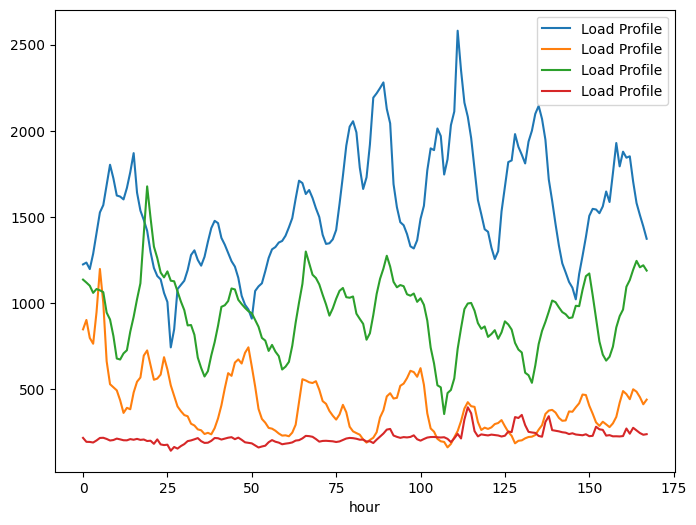

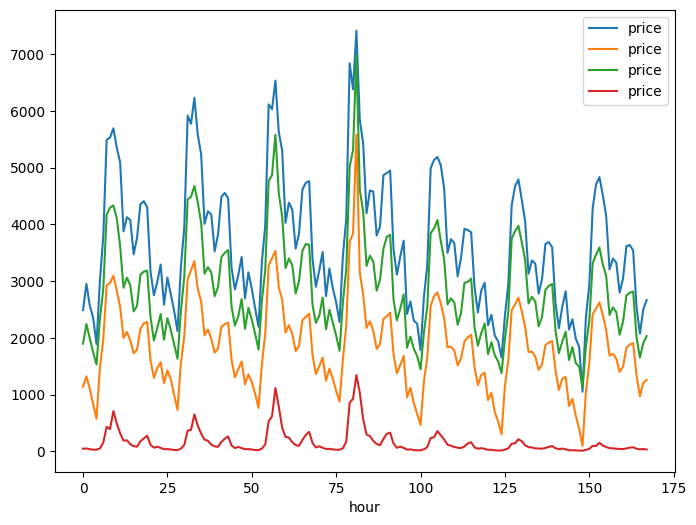

In [42]:
mask = (df_all_weeks["year"] == 2050) * (df_all_weeks["scenario_price"] == "high")
print(df_all_weeks[mask])
# df_all_weeks[mask].plot(x="hour",y=["Load Profile"], by=["typical_week"])
fig, ax = plt.subplots(figsize=(8,6))
bp = df_all_weeks[mask].groupby('period').plot(x="hour",y=["Load Profile"], ax = ax)
fig, ax = plt.subplots(figsize=(8,6))
bp = df_all_weeks[mask].groupby('period').plot(x="hour",y=["price"], ax = ax)

In [43]:
df_melted = df_all_weights.melt(id_vars=["year","scenario_price"]).rename(columns = {"variable":"period","value":"weight"})
print(df_melted)

    year scenario_price period  weight
0   2025            mid      0    13.0
1   2025           high      0    13.0
2   2025            low      0    15.0
3   2030            mid      0    16.0
4   2030           high      0    13.0
..   ...            ...    ...     ...
67  2045           high      3     7.0
68  2045            low      3     9.0
69  2050            mid      3     7.0
70  2050           high      3     7.0
71  2050            low      3     9.0

[72 rows x 4 columns]


In [44]:
print(df_all_weeks)

     period  hour  Load Profile       price  year scenario_price
0         0     0    959.182671  429.517704  2050            low
1         0     1    869.924661  409.822043  2050            low
2         0     2    784.444592  284.863650  2050            low
3         0     3    731.546761  225.464633  2050            low
4         0     4    805.633042  352.766856  2050            low
..      ...   ...           ...         ...   ...            ...
667       3   163    914.932357  599.165035  2025            mid
668       3   164    867.047700  467.880907  2025            mid
669       3   165    755.556706  416.220426  2025            mid
670       3   166    708.111816  406.222702  2025            mid
671       3   167    674.259732  377.348911  2025            mid

[12096 rows x 6 columns]


In [45]:

# Use merge instead of join
df_result = pd.merge(
    df_melted,
    df_all_weeks,
    on=["year", "scenario_price","period"],
    how="inner"  # or "outer", "left", "right" as needed
)
print(df_result)
df_result.to_csv("file_for_ali_4_weeks_168_hours.csv")

       year scenario_price period  weight  hour  Load Profile        price
0      2025            mid      0    13.0     0   1480.254700  1165.832183
1      2025            mid      0    13.0     1   1562.219013  1121.343775
2      2025            mid      0    13.0     2   1517.296635   965.279749
3      2025            mid      0    13.0     3   1622.056575   952.251907
4      2025            mid      0    13.0     4   1806.589681  1111.736455
...     ...            ...    ...     ...   ...           ...          ...
12091  2050            low      3     9.0   163   1563.015728  2021.790311
12092  2050            low      3     9.0   164   1583.815501  1946.365459
12093  2050            low      3     9.0   165   1504.725282  1954.671124
12094  2050            low      3     9.0   166   1436.362548  1797.353471
12095  2050            low      3     9.0   167   1356.528290  1770.611634

[12096 rows x 7 columns]


In [46]:
df_result.groupby(by=["year","scenario_price"]).max()

period     weight  hour  Load Profile        price
year scenario_price                                                   
2025 high                3  16.000000   167   2580.011119  2327.200492
     low                 3  16.000000   167   2579.972470  2000.217565
     mid                 3  16.000000   167   2580.011119  2133.869704
2030 high                3  16.000000   167   2580.011119  2765.121091
     low                 3  16.000000   167   2579.972470  2157.753105
     mid                 3  16.000000   167   2580.164828  2428.167823
2035 high                3  19.000000   167   2580.455336  4236.505798
     low                 3  16.000000   167   2579.972470  2326.934284
     mid                 3  16.000000   167   2580.097373  3129.844493
2040 high                3  17.142857   167   2580.501655  6261.508554
     low                 3  16.000000   167   2579.972470  2569.360838
     mid                 3  18.000000   167   2580.861470  4043.119383
2045 high                3  17.142857   167   2580.501655  6812.142792
     low                 3  16.000000   167   2579.972470  2795.309271
     mid                 3  18.000000   167   2580.861470  4398.669478
2050 high                3  17.142857   167   2580.501655  7411.199557
     low                 3  16.000000   167   2579.972470  3041.127508
     mid                 3  18.000000   167   2580.861470  4785.486489